##### Multiclass-Classification-Using-Keras-Practice
Target Feature - Weather Type

Duplicate Rows Count: 0
Null Cols Count: 0
      Cloudy  Rainy  Snowy  Sunny
3958       0      1      0      0
2239       0      1      0      0
3608       0      0      0      1
Train Loss: 0.37 , Train Accuracy: 0.9
Test Loss: 0.39 , Test Accuracy: 0.89
              precision    recall  f1-score   support

      Cloudy       0.84      0.87      0.85       651
       Rainy       0.89      0.88      0.89       647
       Snowy       0.97      0.93      0.95       701
       Sunny       0.88      0.89      0.89       641

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640



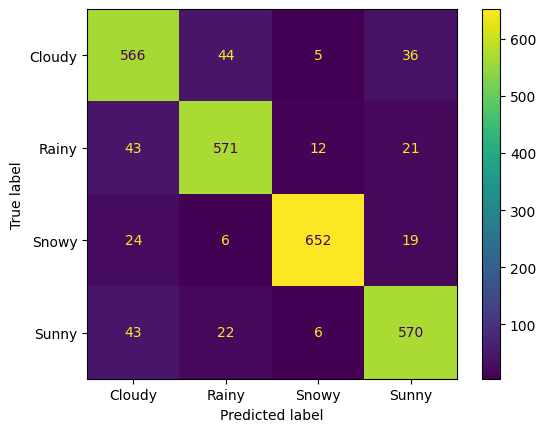

In [1]:
from warnings import filterwarnings; filterwarnings('ignore')

# Step-1: Data Ingestion
# ----------------------

import pandas as pd; df = pd.read_csv('train_weather.csv'); df.head(2)

# Step-2: Data Sanity Checks
# --------------------------

duplicate_count = df.duplicated().sum()
print('Duplicate Rows Count:', duplicate_count)
null_values = df.isna().sum().sum()
print('Null Cols Count:', null_values)

# Step-3: Separate X and Y
# ------------------------

X = df.drop(columns= ["Weather Type"]); Y = df["Weather Type"]

# Step-4: Apply Train Test Split
# ------------------------------

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step-5: Apply Preprocessing on X and Y
# --------------------------------------

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocess X
# ============

cat_cols = X.select_dtypes(include='object').columns.tolist(); 
num_cols = X.select_dtypes(include='number').columns.tolist()

num_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))

pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)]).set_output(transform='pandas')
pre.fit(xtrain)

xtrain_pre = pre.transform(xtrain); xtest_pre = pre.transform(xtest)

# Preprocess Y
# ============

ytrain_pre = pd.get_dummies(ytrain, dtype=int)
ytest_pre = pd.get_dummies(ytest, dtype=int)

print(ytrain_pre.head(3))

# Step-6: Build Neural Network
# ----------------------------

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model = Sequential(
    layers = [
        Input( shape=(xtrain_pre.shape[1],) ),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)), Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)), Dropout(0.2),
        Dense(ytrain_pre.shape[1], activation='softmax')
    ]
)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(patience=5, verbose=False, restore_best_weights=True)
model.fit(xtrain_pre, ytrain_pre, callbacks=[es], verbose=False, epochs=20, validation_split=0.2)

# Step-7: Evaluate Model
# ----------------------

train_loss, train_acc = model.evaluate(xtrain_pre, ytrain_pre, verbose=False)
print( 'Train Loss:', round(train_loss, 2), ', Train Accuracy:', round(train_acc, 2) )

test_loss, test_acc = model.evaluate(xtest_pre, ytest_pre, verbose=False)
print( 'Test Loss:', round(test_loss, 2), ', Test Accuracy:', round(test_acc, 2) )

classes = ytrain_pre.columns.to_list()

def predict_weather(model, x):
  yprob = model.predict(x, verbose=False)
  index = yprob.argmax(axis=1)
  ypred = [classes[i] for i in index]
  return ypred

ytrain_pred = predict_weather(model, xtrain_pre)
ytest_pred = predict_weather(model, xtest_pre)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(ytest, ytest_pred)

from sklearn.metrics import classification_report
print(classification_report(ytest, ytest_pred))


In [2]:
# Step-8: Out of Sample Prediction
# --------------------------------

xnew = pd.read_csv('test_weather.csv')

xnew_pre = pre.transform(xnew)
xnew_probs = model.predict(xnew_pre, verbose=False)
xnew_preds = predict_weather(model, xnew_pre)

xnew['Weather_Predicted'] = xnew_preds
xnew[classes] = xnew_probs.round(4)
xnew.to_csv('test_weather_results.csv')
